## Импорт выгруженных сообщений из Telegram-канала

In [1]:
import json
with open("channel_messages.json", encoding='UTF-8') as jsonFile:
    messages = json.load(jsonFile)
    jsonFile.close()

In [2]:
print(messages[:10])

['"В настоящее время\xa0ВОЗ\xa0не рекомендует проводить поголовную вакцинацию детей и подростков, поскольку бремя тяжелых заболеваний в этих возрастных группах невелико, а высокий охват вакцинацией среди групп, подверженных наибольшему риску тяжелых заболеваний, еще не достигнут во всех странах"', '⚡️ВОЗ не рекомендует проводить поголовную вакцинацию детей и подростков от COVID-19 – заявление', 'Спасибо!', 'Гемотест - не лучшая лаборатория, часто косячат с интересующими вас анализами. А так вам нужен abbot quant rbd - его много где делают', 'О госпитализациях с омикроном в Англии', 'https://www.imperial.ac.uk/mrc-global-infectious-disease-analysis/covid-19/report-50-severity-omicron/', 'Просто сделайте прививку. Даже если "вдруг", то хуже не будет', 'Здравствуйте, уважаемые! Помогите определиться по такому вопросу.\nНе вакцинирована. Собираюсь в ближайшие дни. Ковидом вроде как не болела, но болел супруг. Я была в контакте в течение недели (сначала лечился дома, потом его положили в мо

для наглядности посмотрели на первые 7 сообщений

In [3]:
for message in messages[:7]:
    print(message)

"В настоящее время ВОЗ не рекомендует проводить поголовную вакцинацию детей и подростков, поскольку бремя тяжелых заболеваний в этих возрастных группах невелико, а высокий охват вакцинацией среди групп, подверженных наибольшему риску тяжелых заболеваний, еще не достигнут во всех странах"
⚡️ВОЗ не рекомендует проводить поголовную вакцинацию детей и подростков от COVID-19 – заявление
Спасибо!
Гемотест - не лучшая лаборатория, часто косячат с интересующими вас анализами. А так вам нужен abbot quant rbd - его много где делают
О госпитализациях с омикроном в Англии
https://www.imperial.ac.uk/mrc-global-infectious-disease-analysis/covid-19/report-50-severity-omicron/
Просто сделайте прививку. Даже если "вдруг", то хуже не будет


# Предобработка данных

## Нормализация
убираем пунктуацию, ссылки, двойные пробелы

In [4]:
import pkg_resources
import re, string
import spacy
from tqdm.notebook import tqdm

In [5]:
def simplify_punctuation_and_whitespace(sentence_list):
    norm_sents = []
    print("Normalizing whitespaces and punctuation")
    for sentence in tqdm(sentence_list):
        sent = _replace_urls(sentence)
        sent = _simplify_punctuation(sentence)
        sent = _normalize_whitespace(sent)
        norm_sents.append(sent)
    return norm_sents

def _replace_urls(text):
    url_regex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    text = re.sub(url_regex, "<URL>", text)
    return text

def _simplify_punctuation(text):
    # This function simplifies doubled or more complex punctuation. The exception is '...'.
    corrected = str(text)
    corrected = re.sub(r'([!?,;])\1+', r'\1', corrected)
    corrected = re.sub(r'\.{2,}', r'...', corrected)
    return corrected

def _normalize_whitespace(text):
    # This function normalizes whitespaces, removing duplicates
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip(" ")

## Лемматизация

In [6]:
def lemmatize(sentence_list):
    nlp = spacy.load("ru_core_news_sm")
    new_norm=[]
    print("Lemmatizing Sentences")
    for sentence in tqdm(sentence_list):
        new_norm.append(_lemmatize_text(sentence, nlp).strip())
    return new_norm

def _lemmatize_text(sentence, nlp):
    sent = ""
    doc = nlp(sentence)
    for token in doc:
        sent+=" "+token.lemma_
    return sent

In [7]:
def normalization_pipeline(sentences):
    sentences = simplify_punctuation_and_whitespace(sentences)
    sentences = lemmatize(sentences)
    return sentences

In [8]:
messages_normed = normalization_pipeline(messages)

Normalizing whitespaces and punctuation



Lemmatizing Sentences


## Токенизация

In [9]:
def tokenize(text):
    text = [string.lower() for string in text]
    text = re.sub(r'[^а-яА-Я ^0-9 +]', '', str(text))
    return text.split()

In [10]:
tokenized_original = tokenize(messages)
print('данные до предобработки:')
print(tokenized_original[:15])
tokenized_normalized = tokenize(messages_normed)
print('данные после нормализации и лемматизации:')
print(tokenized_normalized[:15])

данные до предобработки:
['в', 'настоящее', 'время0воз0не', 'рекомендует', 'проводить', 'поголовную', 'вакцинацию', 'детей', 'и', 'подростков', 'поскольку', 'бремя', 'тяжелых', 'заболеваний', 'в']
данные после нормализации и лемматизации:
['в', 'настоящий', 'время', '0', 'воз', '0', 'не', 'рекомендовать', 'проводить', 'поголовный', 'вакцинация', 'ребнок', 'и', 'подросток', 'поскольку']


## Удаление стоп-слов

In [11]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
import copy
russian_stopwords = stopwords.words("russian")
print('удаляем русские стоп-слова: ')
print(russian_stopwords)
def remove_stopwords(text):
    text_new = copy.deepcopy(text)
    print('removing stop-words')
    for word in tqdm(text):
        if word in russian_stopwords:
            text_new.remove(word)
    return text_new

удаляем русские стоп-слова: 
['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разв

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
preprocessed_data = remove_stopwords(tokenized_normalized)

removing stop-words


# Промежуточные результаты

In [13]:
import numpy as np
print('количество слов до предобработки данных: ', len(tokenized_original))
print('количество слов после предобработки данных: ', len(preprocessed_data))
print('количество уникальных слов до предобработки данных: ', np.unique(tokenized_original).shape[0])
print('количество уникальных слов после нормализации и лемматизации: ', np.unique(tokenized_normalized).shape[0])
unique_words = np.unique(preprocessed_data)
print('количество уникальных слов после нормализации, лемматизации и удаления стоп-слов: ', unique_words.shape[0])

количество слов до предобработки данных:  79342
количество слов после предобработки данных:  49798
количество уникальных слов до предобработки данных:  16630
количество уникальных слов после нормализации и лемматизации:  9918
количество уникальных слов после нормализации, лемматизации и удаления стоп-слов:  9780


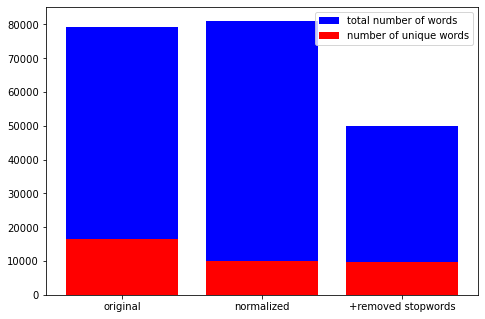

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['original', 'normalized', '+removed stopwords']
lengthes = [len(tokenized_original), len(tokenized_normalized), len(preprocessed_data)]
ax.bar(labels, lengthes, color='b')
uq_lengthes = [np.unique(tokenized_original).shape[0], np.unique(tokenized_normalized).shape[0], np.unique(preprocessed_data).shape[0]]
ax.bar(labels, uq_lengthes, color='r')
ax.legend(labels=['total number of words', 'number of unique words'])
plt.show()

In [15]:
def toDict():
    words_dict = {}
    for word in unique_words:
        words_dict[word] = 0
    for word in preprocessed_data:
        words_dict[word] += 1
    return words_dict

In [16]:
def sort_dict(text):
    dict1 = toDict()
    sorted_values = sorted(dict1.values()) 
    sorted_dict = {}
    for i in sorted_values:
        for k in dict1.keys():
            if dict1[k] == i:
                sorted_dict[k] = dict1[k]
                break
    return sorted_dict

In [17]:
sorted_dict = sort_dict(preprocessed_data)
print(sorted_dict)

{'+10': 1, '01072022': 2, '025': 3, '044762': 4, '150': 5, '+1': 6, '120': 7, '24': 8, '1000': 9, '23': 10, '18': 11, '14': 12, '13': 13, '27': 14, 'антиваксеров': 15, '11': 16, '38': 17, 'ага': 18, '16': 19, '15': 20, '0900': 21, '000': 22, '60': 23, '50': 24, '2021': 25, '7': 26, 'близкий': 27, 'бустер': 28, 'волна': 29, '30': 30, 'лекарство': 31, 'жизнь': 32, '12': 33, 'больница': 34, 'взять': 35, '100': 36, 'всем': 37, '10': 38, 'видимо': 39, 'главный': 40, 'бау': 41, '20': 42, '4': 43, 'голиков': 44, 'группа': 45, 'брать': 46, 'воз': 47, 'мало': 48, 'значить': 49, 'мрнк': 50, 'вакцинировать': 51, 'госпитализация': 52, 'любой': 53, 'количество': 54, 'высокий': 55, 'сегодня': 56, 'лгкий': 57, 'данные': 58, 'место': 60, 'понимать': 61, 'именно': 62, 'защита': 63, 'понять': 64, 'интересный': 65, 'выявить': 67, 'вроде': 68, 'доза': 69, '5': 70, 'видеть': 71, 'вариант': 72, 'заражение': 73, '0': 74, 'декабрь': 75, 'почему': 76, 'маска': 77, 'пройти': 78, '19': 79, 'иметь': 80, 'антитело

In [18]:
def most_used_words(dict1):
    total_num_words = sum(dict1.values())
    most_used = []
    word_count = []
    total_most_used = 0
    word_iterator = iter(sorted(dict1.items(), key=lambda x: x[1], reverse=True))
    while total_most_used < total_num_words*0.8:
        word_tuple = next(word_iterator)
        most_used.append(word_tuple[0])
        total_most_used+=word_tuple[1]
        word_count.append(word_tuple[1])
    return most_used, word_count

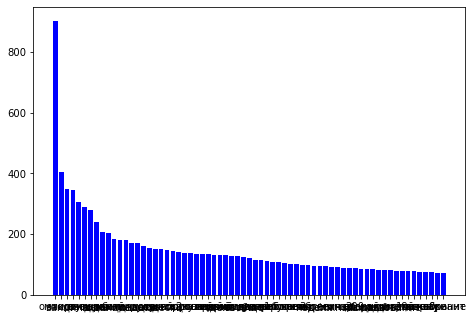

['это', 'омикрон', 'вакцина', 'мочь', 'весь', 'спутник', 'год', 'день', 'штамм', 'новый', 'коронавирус', 'болеть', 'вакцинация', 'ещ', 'делать', 'пока', 'код', 'случай', 'знать', 'месяц', 'говорить', '2', 'сказать', 'хороший', 'россия', 'нужный', 'врач', 'первый', 'свой', 'сделать', 'прививка', 'москва', 'вообще', 'иммунитет', 'думать', 'вопрос', '1', 'вирус', 'переболеть', 'заболеть', 'очень', 'время', '3', 'антител', 'неделя', '+', 'болезнь', 'должный', 'ничто', 'пцр', 'вс', '200', 'второй', 'каждый', 'анализ', 'давать', 'исследование', 'антитело', 'иметь', '19', 'пройти', 'маска', 'почему', 'декабрь', '0', 'заражение', 'вариант']


In [19]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
most_used, counts = most_used_words(sorted_dict)
labels = most_used
lengthes = counts
ax.bar(labels, lengthes, color='b')
plt.show()
print(most_used)

# Векторное представление слов

In [20]:
import torch
from torch import nn

In [21]:
word2idx = {w: idx for (idx, w) in enumerate(unique_words)}
idx2word = {idx: w for (idx, w) in enumerate(unique_words)}

In [22]:
def CBOW(raw_text, window_size=2):  # continuous bag of words
    data = []
    for i in range(window_size, len(raw_text) - window_size):
        context = [raw_text[i - window_size], raw_text[i - (window_size - 1)], raw_text[i + (window_size - 1)], raw_text[i + window_size]]
        target = raw_text[i]
        data.append((context, target))
    return data
class CBOW_Model(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_Model, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()
        self.linear2 = nn.Linear(128, vocab_size)
      

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        return out
def make_context_vector(context, word2idx):
    vec = []
    for word in context:
        vec.append(word2idx[word])
    return torch.tensor(vec)

In [24]:
cbow = CBOW(preprocessed_data)
print(cbow[10:20])

[(['подросток', 'поскольку', 'тяжлый', 'заболевание'], 'бремя'), (['поскольку', 'бремя', 'заболевание', 'возрастной'], 'тяжлый'), (['бремя', 'тяжлый', 'возрастной', 'группа'], 'заболевание'), (['тяжлый', 'заболевание', 'группа', 'небольшой'], 'возрастной'), (['заболевание', 'возрастной', 'небольшой', 'высокий'], 'группа'), (['возрастной', 'группа', 'высокий', 'охват'], 'небольшой'), (['группа', 'небольшой', 'охват', 'вакцинация'], 'высокий'), (['небольшой', 'высокий', 'вакцинация', 'среди'], 'охват'), (['высокий', 'охват', 'среди', 'группа'], 'вакцинация'), (['охват', 'вакцинация', 'группа', 'подверженный'], 'среди')]


In [25]:
model = CBOW_Model(len(unique_words), 5)
print(model)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

CBOW_Model(
  (embeddings): Embedding(9780, 5)
  (linear1): Linear(in_features=5, out_features=128, bias=True)
  (activation_function1): ReLU()
  (linear2): Linear(in_features=128, out_features=9780, bias=True)
)


In [ ]:
# training
for epoch in tqdm(range(10)):
    total_loss = 0
    for context, target in cbow:
        context_vector = make_context_vector(context, word2idx) 
        output = model(context_vector)
        target = torch.tensor([word2idx[target]])
        total_loss += loss_function(output, target)
    #optimize at the end of each epoch
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()